In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = np.linspace(0,50,501)         # alternate           np.arange(0,50.1,0.1)
y = np.sin(X)

<AxesSubplot:>

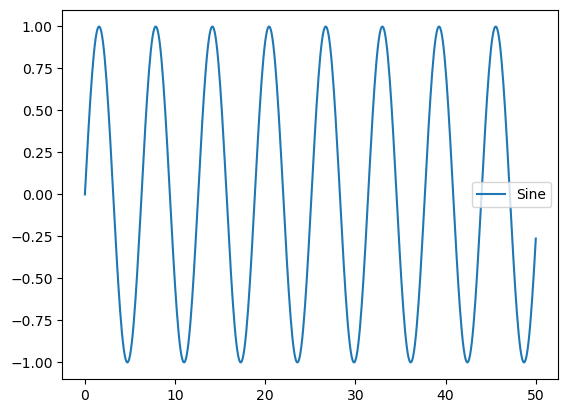

In [3]:
df = pd.DataFrame(data=y,index=X,columns=['Sine'])
df.plot()

### Train test split

find length of df : len(df) then Select how much data you needed to test. Split df based on need.

In [4]:
test_percent = 0.1
test_point = np.round(len(df)*test_percent)
test_ind = int(len(df) - test_point)

# or simply say that last 50 points be testing

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [5]:
train.tail()

,Sine
44.6,0.579164
44.7,0.657656
44.8,0.729577
44.9,0.794208
45.0,0.850904


In [6]:
test.head()

,Sine
45.1,0.899097
45.2,0.938307
45.3,0.968142
45.4,0.988304
45.5,0.998591


In [7]:
## Scale Data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [8]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# define generator
length = 50 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [9]:
len(scaled_train)

451

In [10]:
len(generator) # n_input = 10

401

In [11]:
# What does the first batch look like?   Its simple that using 10 history points to predict the next.  
X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[4.99999116e-01 5.49916225e-01 5.99334579e-01 6.47760405e-01
 6.94709850e-01 7.39713809e-01 7.82322618e-01 8.22110545e-01
 8.58680040e-01 8.91665714e-01 9.20737985e-01 9.45606372e-01
 9.66022399e-01 9.81782075e-01 9.92727935e-01 9.98750612e-01
 9.99789928e-01 9.95835500e-01 9.86926839e-01 9.73152957e-01
 9.54651478e-01 9.31607263e-01 9.04250562e-01 8.72854714e-01
 8.37733417e-01 7.99237589e-01 7.57751870e-01 7.13690771e-01
 6.67494535e-01 6.19624741e-01 5.70559686e-01 5.20789614e-01
 4.70811810e-01 4.21125636e-01 3.72227539e-01 3.24606094e-01
 2.78737119e-01 2.35078919e-01 1.94067715e-01 1.56113277e-01
 1.21594831e-01 9.08572769e-02 6.42077324e-02 4.19124713e-02
 2.41942605e-02 1.12301346e-02 3.14962674e-03 3.34747619e-05
 1.91281421e-03 8.76886734e-03]
Predict this y: 
 [[0.02053313]]


In [12]:
scaled_train[:11]  # see first 10 points as 'x' of first batch and 11th point as 'y' of first batch simply batch move forward.

array([[0.49999912],
       [0.54991622],
       [0.59933458],
       [0.64776041],
       [0.69470985],
       [0.73971381],
       [0.78232262],
       [0.82211054],
       [0.85868004],
       [0.89166571],
       [0.92073798]])

In [13]:
### Create the Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

# We're only using one feature in our time series
n_features = 1

# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(50,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit model
model.fit(generator,epochs=3)

Epoch 1/3
401/401 [==============================] - 4s 8ms/step - loss: 0.0014
Epoch 2/3
401/401 [==============================] - 3s 8ms/step - loss: 2.0286e-04
Epoch 3/3
401/401 [==============================] - 3s 8ms/step - loss: 1.0629e-04


<AxesSubplot:>

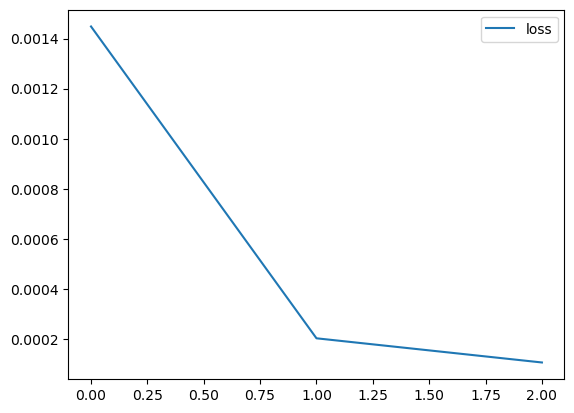

In [15]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [16]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 33ms/step


In [17]:
## Inverse Transformations and Compare bcoz prediction is a scaled value not original

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

C:\Users\Gabbar\AppData\Local\Temp\ipykernel_26132\3594179693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [18]:
test.head()

,Sine,Predictions
45.1,0.899097,0.858348
45.2,0.938307,0.873437
45.3,0.968142,0.885362
45.4,0.988304,0.888638
45.5,0.998591,0.875883


<AxesSubplot:>

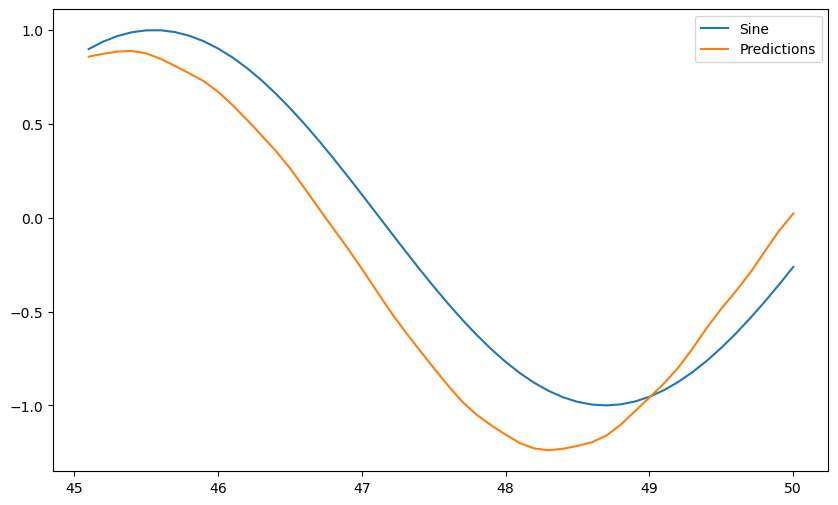

In [19]:
test.plot(figsize= (10,6))

Epoch 1/20


C:\Users\Gabbar\AppData\Local\Temp\ipykernel_26132\412338190.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


402/402 [==============================] - 10s 19ms/step - loss: 0.0178 - val_loss: 9.5178e-05
Epoch 2/20
402/402 [==============================] - 7s 18ms/step - loss: 1.8564e-04 - val_loss: 7.6463e-05
Epoch 3/20
402/402 [==============================] - 7s 17ms/step - loss: 2.9828e-04 - val_loss: 3.4930e-05
Epoch 4/20
402/402 [==============================] - 7s 17ms/step - loss: 3.4259e-04 - val_loss: 0.0026
Epoch 5/20
402/402 [==============================] - 7s 17ms/step - loss: 4.3740e-04 - val_loss: 1.2960e-05
Epoch 6/20
402/402 [==============================] - 7s 16ms/step - loss: 9.1828e-05 - val_loss: 1.4654e-04
Epoch 7/20
1/1 [==============================] - 0s 19ms/step


C:\Users\Gabbar\AppData\Local\Temp\ipykernel_26132\412338190.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = true_predictions


<AxesSubplot:>

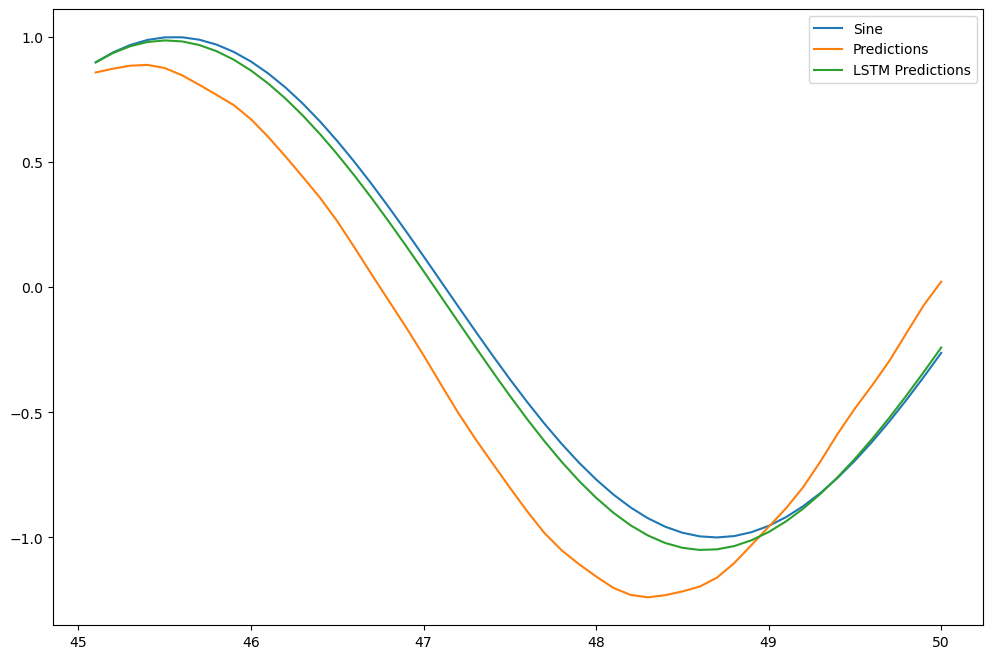

In [20]:
# Same model with lstm and early stopping

## Adding in Early Stopping and Validation Generator
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=2)

length = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

# LSTMS

model = Sequential()
model.add(LSTM(50,input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# IGNORE WARNINGS
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))